# Imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.distributions.bernoulli import Bernoulli
import matplotlib.pyplot as plt
import pandas as pd
import time

# Model definition

## Setting the device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)
torch.set_printoptions(linewidth=150)
print(device)

cuda


## Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, D, n_hidden, n_latent):
        super(Encoder, self).__init__()
        self.l_enc1 = nn.Linear(D, n_hidden)
        self.l_enc2 = nn.Linear(n_hidden, n_hidden)
        self.q_mu = nn.Linear(n_hidden, n_latent)
        self.q_logstd = nn.Linear(n_hidden, n_latent)

    def forward(self, x):
        x = torch.tanh(self.l_enc1(x))
        x = torch.tanh(self.l_enc2(x))
        q_mu = self.q_mu(x)
        q_logstd = torch.clip(self.q_logstd(x), -10, 10)
        return q_mu, q_logstd

## Function to sample the latent space

In [ ]:
def sample_latent(q_mu, q_logstd, n_samples):
    q_z = Normal(q_mu, torch.exp(q_logstd))
    l_z = q_z.rsample([n_samples])  # Shape: [n_samples, batch_size, dl]
    l_z = l_z.permute(1, 0, 2)  # [batch_size, n_samples, dl]
    return l_z, q_z

## Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, n_latent, D):
        super(Decoder, self).__init__()
        self.mu = nn.Linear(n_latent, D)
        self.logits_layer = nn.Sequential(
                                          nn.Linear(D, D),
                                         # nn.ReLU(),
                                         # nn.Linear(D, D),
                                        )
                                                                                  #linear layer for logits calculation
        self.logstd = torch.tensor(0.0, requires_grad=True, device=device)

    def forward(self, l_z, x_pl, s_pl):
        mu = self.mu(l_z)  # Shape [batch_size, n_samples, D]
        p_x_given_z = Normal(mu, torch.exp(self.logstd))

        l_out_mixed = mu * (1 - s_pl.unsqueeze(1)) + (x_pl * s_pl).unsqueeze(1)
        logits = self.logits_layer(l_out_mixed)
        p_s_given_x = Bernoulli(logits=logits)

        return p_x_given_z, p_s_given_x, l_out_mixed

## Loss function

In [ ]:
def compute_loss(x_pl, s_pl, q_z, l_z, p_x_given_z, p_s_given_x, n_pl):
    log_p_x_given_z = torch.sum((s_pl.unsqueeze(1) * p_x_given_z.log_prob(x_pl.unsqueeze(1))), dim=-1)

    q_z2 = Normal(q_z.loc.unsqueeze(1), q_z.scale.unsqueeze(1))
    log_q_z_given_x = torch.sum(q_z2.log_prob(l_z), dim=-1)

    prior = Normal(0.0, 1.0)
    log_p_z = torch.sum(prior.log_prob(l_z), dim=-1)

    log_p_s_given_x = torch.sum(p_s_given_x.log_prob(s_pl.unsqueeze(1)), dim=-1)

    l_w = log_p_x_given_z + log_p_z - log_q_z_given_x
    log_sum_w = torch.logsumexp(l_w, dim=1)
    log_avg_weight = log_sum_w - torch.log(torch.tensor(n_pl, dtype=torch.float32, device=device))
    MIWAE = torch.mean(log_avg_weight)

    l_w_notMIWAE = log_p_x_given_z + log_p_s_given_x + log_p_z - log_q_z_given_x
    log_sum_w_notMIWAE = torch.logsumexp(l_w_notMIWAE, dim=1)
    log_avg_weight_notMIWAE = log_sum_w_notMIWAE - torch.log(torch.tensor(n_pl, dtype=torch.float32, device=device))
    notMIWAE = torch.mean(log_avg_weight_notMIWAE)

    return MIWAE, notMIWAE, log_p_x_given_z , log_p_s_given_x , log_p_z , log_q_z_given_x

## Training function

In [ ]:
import matplotlib.pyplot as plt

def train_model(encoder, decoder, Xz, S, sample_latent, compute_loss, max_iter=1000, lr=1e-3, n_pl=10, device=device, loss_choice='MIWAE'):
    encoder.to(device)
    decoder.to(device)

    optimizer = optim.Adam(
        list(encoder.parameters()) + list(decoder.parameters()) + [decoder.logstd],
        lr=lr
    )

    Xz_tensor = torch.tensor(Xz, dtype=torch.float32, device=device)  # Move to device
    S_tensor = torch.tensor(S, dtype=torch.float32, device=device)    # Move to device

    # Initialize lists to store loss components
    log_p_x_list = []
    log_p_s_list = []
    log_p_z_list = []
    log_q_z_list = []
    MIWAE_list = []
    notMIWAE_list = []

    for i in range(max_iter):
        q_mu, q_logstd = encoder(Xz_tensor)
        l_z, q_z = sample_latent(q_mu, q_logstd, n_pl)

        p_x_given_z, p_s_given_x, l_out_mixed = decoder(l_z, Xz_tensor, S_tensor)

        MIWAE, notMIWAE, log_p_x_given_z, log_p_s_given_x, log_p_z, log_q_z_given_x = compute_loss(
            Xz_tensor, S_tensor, q_z, l_z, p_x_given_z, p_s_given_x, n_pl
        )

        # Choose the loss based on the specified loss_choice
        if loss_choice == 'MIWAE':
            loss = -MIWAE
        elif loss_choice == 'notMIWAE':
            loss = -notMIWAE

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss components for plotting
        log_p_x_list.append(log_p_x_given_z.mean().item())
        log_p_s_list.append(log_p_s_given_x.mean().item() if log_p_s_given_x is not None else 0)
        log_p_z_list.append(log_p_z.mean().item())
        log_q_z_list.append(log_q_z_given_x.mean().item())
        MIWAE_list.append(-MIWAE.item())
        notMIWAE_list.append(-notMIWAE.item())

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")

    # Plot the loss components at the end of training
    plt.figure(figsize=(12, 8))
    plt.plot(log_p_x_list, label='log_p_x_given_z')
    plt.xlabel('Iterations')
    plt.ylabel('Loss Component Value')
    plt.title('Log(p(x|z)) Over Training Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(12, 8))
    plt.plot(log_p_s_list, label='log_p_s_given_x')
    plt.xlabel('Iterations')
    plt.ylabel('Loss Component Value')
    plt.title('Log(p(s|x)) Over Training Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(12, 8))
    plt.plot(log_p_z_list, label='log_p_z')
    plt.plot(log_q_z_list, label='log_q_z_given_x')
    plt.xlabel('Iterations')
    plt.ylabel('Loss Component Value')
    plt.title('Log(p(z)) and Log(q(z|x)) Over Training Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(12, 8))
    plt.plot(MIWAE_list, label='MIWAE', linestyle='--')
    plt.plot(notMIWAE_list, label='notMIWAE', linestyle='--')
    plt.xlabel('Iterations')
    plt.ylabel('Loss Component Value')
    plt.title('Loss Components Over Training Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()


## Compute the reconstruted missing values :

In [ ]:
# Function to generate Xmix, combining observed and imputed values
def create_Xreconstructed(encoder,decoder, Xorg, Xnan, L, device, loss_choice = 'MIWAE'):
    """
    Function to create Xmix, a data matrix with observed values preserved
    and missing values filled with imputed data.

    Args:
        sess: TensorFlow session for evaluating the computational graph.
        Xorg: Original data matrix with no missing values.
        Xnan: Data matrix with NaN values for missing entries.
        L: Number of importance sampling points for the latent space.

    Returns:
        Xmix: A matrix where observed values are kept, and missing values are imputed.

    """
    # Put encoder and decoder in evaluation mode
    encoder.eval()
    decoder.eval()

    N = len(Xorg)  # Total number of samples

    # Replace NaNs in Xnan with 0s to initialize imputation
    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0

    # Create binary mask S: 1 for observed values, 0 for missing values
    S = np.array(~np.isnan(Xnan), dtype=np.float32)

    # Define a helper softmax function for normalizing importance weights
    def softmax(x):
        e_x = torch.exp(x - torch.max(x, dim=1, keepdim=True)[0])
        return e_x / e_x.sum(dim=1, keepdim=True)

    # Helper function to compute imputation for a single sample
    def imp(xz, s, L):
        # Convert inputs to PyTorch tensors
        xz_tensor = torch.tensor(xz, dtype=torch.float32).to(device)
        s_tensor = torch.tensor(s, dtype=torch.float32).to(device)
        # Forward pass through encoder
        q_mu, q_logstd = encoder(xz_tensor)
        l_z, q_z = sample_latent(q_mu, q_logstd, L)

        # Forward pass through decoder with latent samples and mask
        p_x_given_z, p_s_given_x, l_out_mixed = decoder(l_z, xz_tensor, s_tensor)

        # Log p(x|z)
        log_p_x_given_z = torch.sum((s_tensor.unsqueeze(1) * p_x_given_z.log_prob(xz_tensor.unsqueeze(1))), dim=-1)

        # Log q(z|x)
        q_z2 = Normal(q_z.loc.unsqueeze(1), q_z.scale.unsqueeze(1))
        log_q_z_given_x = torch.sum(q_z2.log_prob(l_z), dim=-1)

        # Log p(z)
        prior = Normal(0.0, 1.0)
        log_p_z = torch.sum(prior.log_prob(l_z), dim=-1)



        # Calculate importance weights with softmax
        if loss_choice == 'notMIWAE':
            # Log p(s|x)
            log_p_s_given_x = torch.sum(p_s_given_x.log_prob(s_tensor.unsqueeze(1)), dim=-1)

            wl = softmax(log_p_x_given_z + log_p_s_given_x + log_p_z - log_q_z_given_x)
        else:
            wl = softmax(log_p_x_given_z + log_p_z - log_q_z_given_x)

        mu = decoder.mu(l_z)
        # Compute imputed values by mixing predicted means (_mu) using weights (wl)
        xm = torch.sum( (mu.T * wl.T).T, axis=1)

        # Combine observed and imputed values to form xmix
        xmix = xz_tensor + xm * (1 - s_tensor)

        return xmix.cpu().detach().numpy()

    # Initialize matrix to store final Xmix values
    Xmix = np.zeros_like(Xorg)

    # Loop over each sample to apply imputation
    for i in range(N):
        # Select the current sample and corresponding mask
        xz = Xz[i, :][None, :]
        s = S[i, :][None, :]

        # Generate imputed values for the sample
        xmix = imp(xz, s, L)

        # Store the result in Xmix
        Xmix[i, :] = xmix

        # Print progress every 100 samples
        if i % 100 == 0:
            print(f'{i} / {N}')

    return Xmix


## RMSE Computation

In [ ]:
import torch
import numpy as np

# Unified function to calculate the RMSE for imputing missing values
def imputationRMSE(X, Xreconstructed, S):
  return np.sqrt(np.sum((X - Xreconstructed) ** 2 * (1 - S)) / np.sum(1 - S))


# Homemade Examples

## Gaussian distribution clipped by the mean

### Data creation
We generate a 2D Gaussian distribution.

In [ ]:
def get_gaussian_distribution(mean, cov, n_samples):
  return np.random.multivariate_normal(mean, cov, n_samples)


# Define the mean and covariance for the 2D Gaussian
mean_v1 = [0, 0]  # Centered at the origin
cov_v1 = [[1, 0.8], [0.8, 1]]  # Diagonal values (variance) and off-diagonals (correlation)
n_samples_gaussian = 500

X_gaussian = get_gaussian_distribution(mean_v1, cov_v1, n_samples_gaussian)

# Get the main variables :
N, D = X_gaussian.shape
n_latent = D - 1

### Missing process definition
The missing values mask is defined as follows: for each sample, the $x_1$ component is masked if it exceeds the mean of all $x_1$  values in the dataset, which in this case is 0.

In [ ]:
X_gaussian_nan = X_gaussian.copy()
X_gaussian_clipped = X_gaussian.copy()

mean = np.mean(X_gaussian_nan[:, :1], axis=0)
ix_larger_than_mean = X_gaussian_nan[:, :1] > mean

X_gaussian_nan[:, :1][ix_larger_than_mean] = np.nan
X_gaussian_clipped[:, :1][ix_larger_than_mean] = 0

S_gaussian = np.array(~np.isnan(X_gaussian_nan), dtype=np.float32)

### Function to plot the distribution

In [ ]:
def plot_gaussian_distribution(X, mean, cov, Xclipped = None, Xreconstructed = None):
    # Visualization of the clipped data with mask
    plt.scatter(X[:, 0], X[:, 1], c='lightgrey', alpha=0.5, label='Original Data')

    if Xreconstructed is not None:
        plt.scatter(Xreconstructed[:, 0], Xreconstructed[:, 1], c='red', edgecolor='k', s=50, label='Reconstructed Data')

    if Xclipped is not None:
        plt.scatter(Xclipped[:, 0], Xclipped[:, 1], c='dodgerblue', edgecolor='k', s=50, label='Clipped Data')


    plt.xlabel("X1", fontsize=14)
    plt.ylabel("X2", fontsize=14)



    plt.scatter(mean[0], mean[1], c='red', s=100, label='Mean', marker='x')
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    for j in range(1, 4):
        ell_radius_x = j * lambda_[0]
        ell_radius_y = j * lambda_[1]
        ellipse = plt.matplotlib.patches.Ellipse(xy=(mean[0], mean[1]),
                                                width=ell_radius_x * 2, height=ell_radius_y * 2,
                                                angle=np.rad2deg(np.arccos(v[0, 0])),
                                                color='grey', alpha=0.2 * (4 - j), linestyle='--')
        plt.gca().add_patch(ellipse)

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)


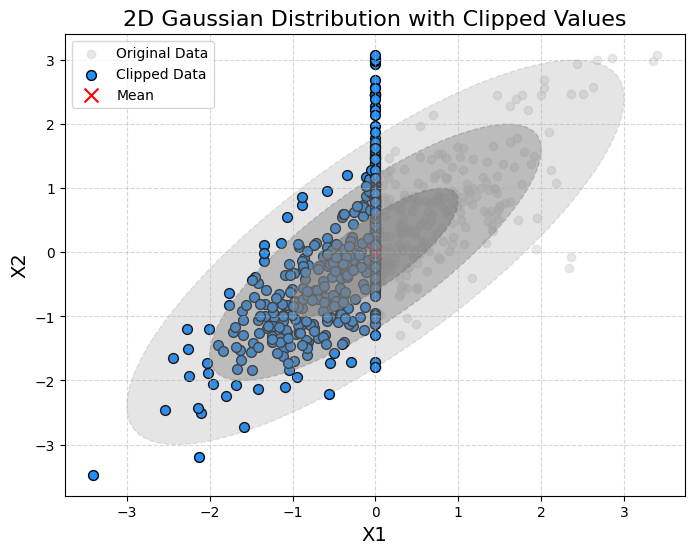

In [ ]:
plt.figure(figsize=(8, 6))
plot_gaussian_distribution(X_gaussian, mean_v1, cov_v1, Xclipped=X_gaussian_clipped)
plt.title("2D Gaussian Distribution with Clipped Values", fontsize=16)
plt.show()

### Train a VAE on the Gaussian distribution

Iteration 0, Loss: 2.6408681869506836
Iteration 100, Loss: 2.606264352798462
Iteration 200, Loss: 2.5874030590057373
Iteration 300, Loss: 2.5721895694732666
Iteration 400, Loss: 2.5621182918548584
Iteration 500, Loss: 2.5482399463653564
Iteration 600, Loss: 2.5349605083465576
Iteration 700, Loss: 2.5228216648101807
Iteration 800, Loss: 2.5113515853881836
Iteration 900, Loss: 2.498894691467285
Iteration 1000, Loss: 2.48722243309021
Iteration 1100, Loss: 2.477219343185425
Iteration 1200, Loss: 2.4677255153656006
Iteration 1300, Loss: 2.45462703704834
Iteration 1400, Loss: 2.4452064037323
Iteration 1500, Loss: 2.432586193084717
Iteration 1600, Loss: 2.4181032180786133
Iteration 1700, Loss: 2.408017635345459
Iteration 1800, Loss: 2.3996999263763428
Iteration 1900, Loss: 2.3867297172546387
Iteration 2000, Loss: 2.3740298748016357
Iteration 2100, Loss: 2.361478805541992
Iteration 2200, Loss: 2.3507637977600098
Iteration 2300, Loss: 2.339794874191284
Iteration 2400, Loss: 2.3256337642669678
I

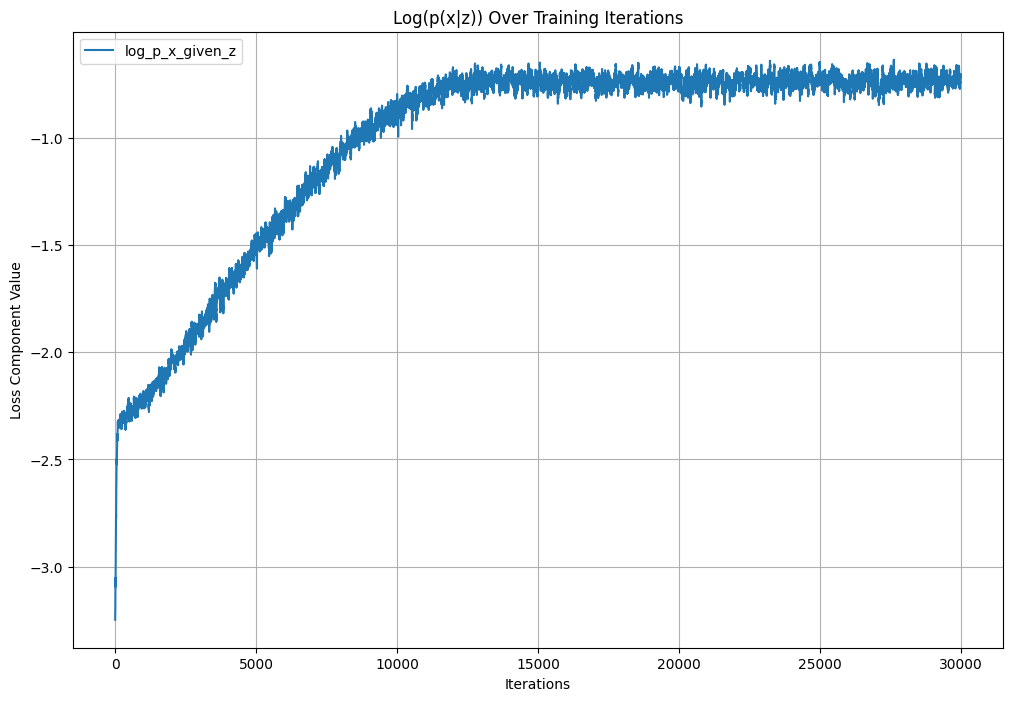

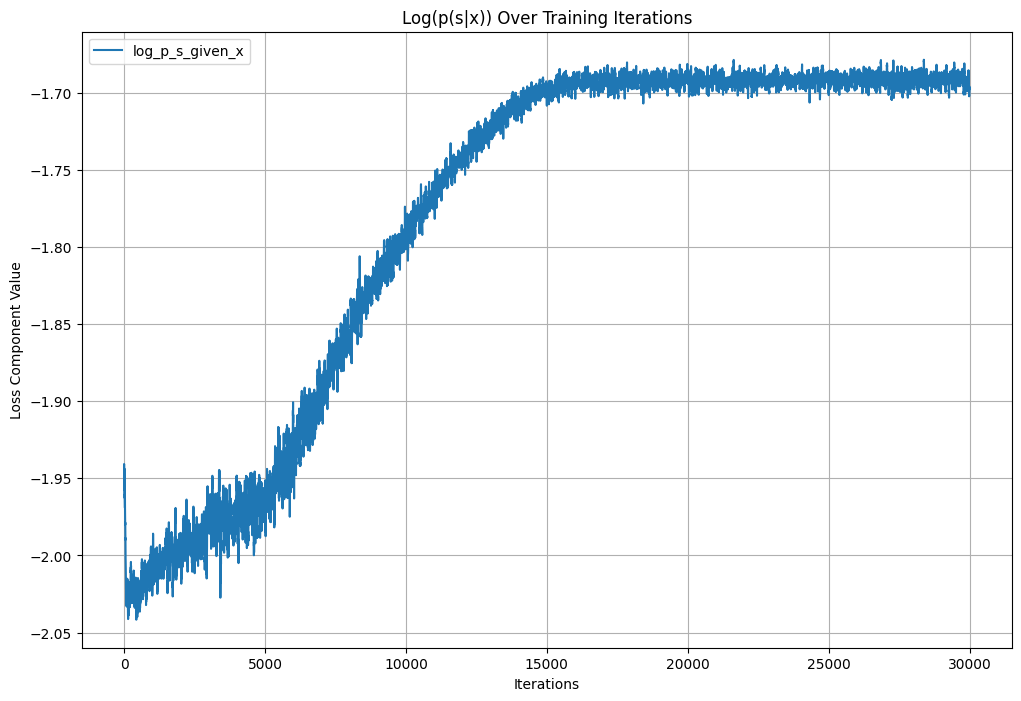

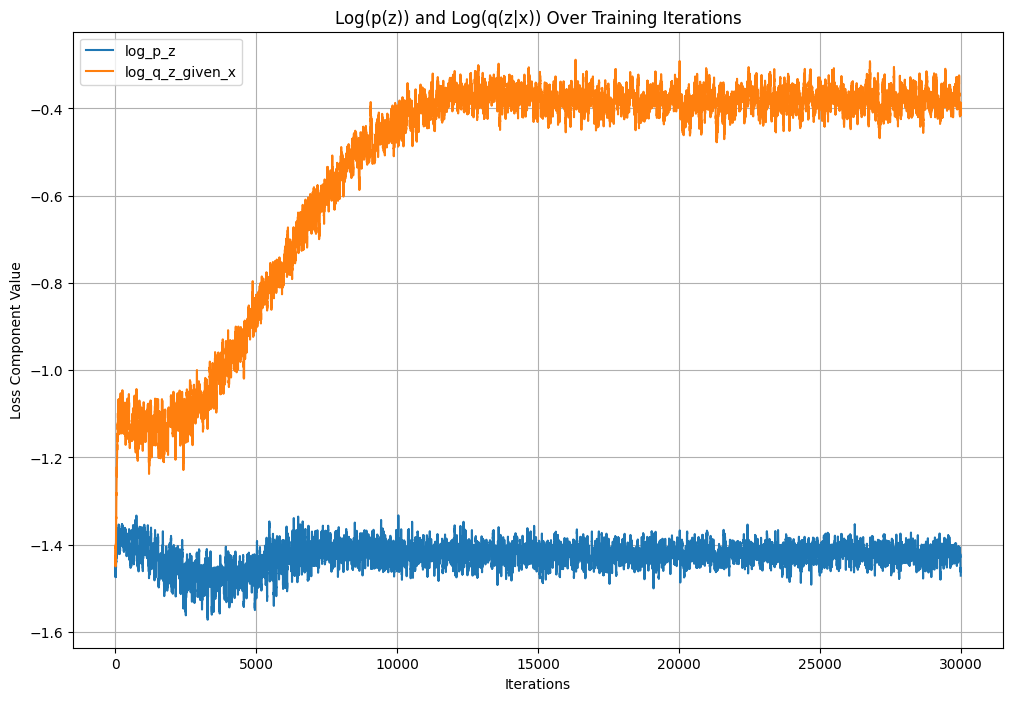

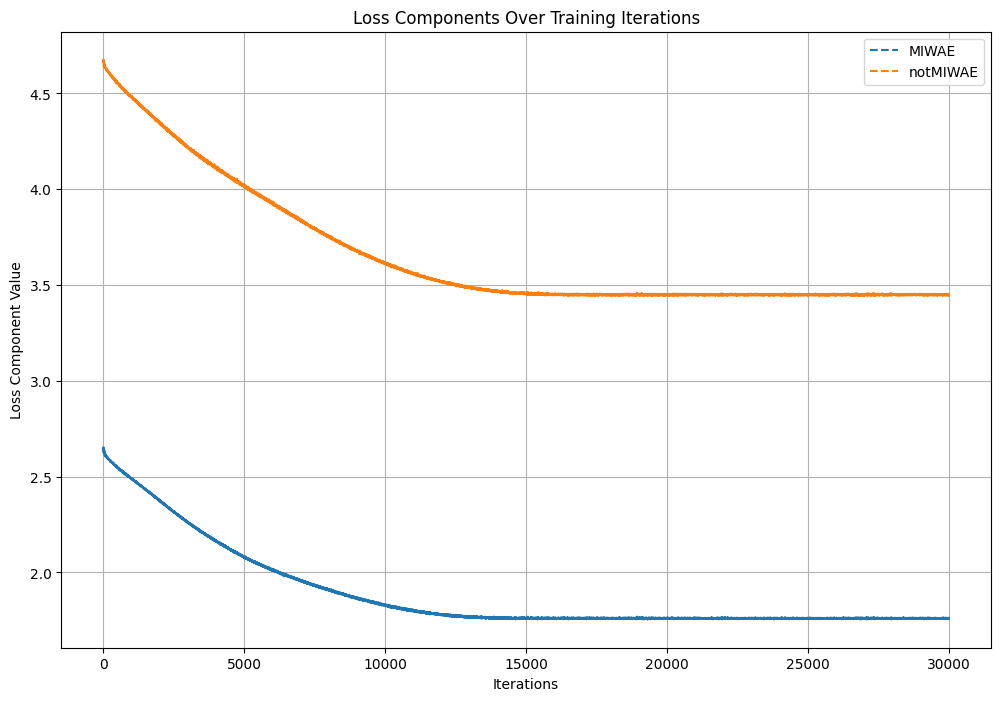

In [ ]:
N, D = X_gaussian.shape
n_latent = D - 1
n_hidden = 128
n_samples = 20
max_iter = 30000
batch_size = 16

encoder = Encoder(D, n_hidden, n_latent)
decoder = Decoder(n_latent, D)
loss_choice = 'MIWAE' # 'notMIWAE' or 'MIWAE'
train_model(encoder, decoder, X_gaussian_clipped, S_gaussian, sample_latent, compute_loss, max_iter, lr=0.0001, device = device, n_pl=n_samples)

### Obtain the reconstructed data and plot it :

0 / 500
100 / 500
200 / 500
300 / 500
400 / 500


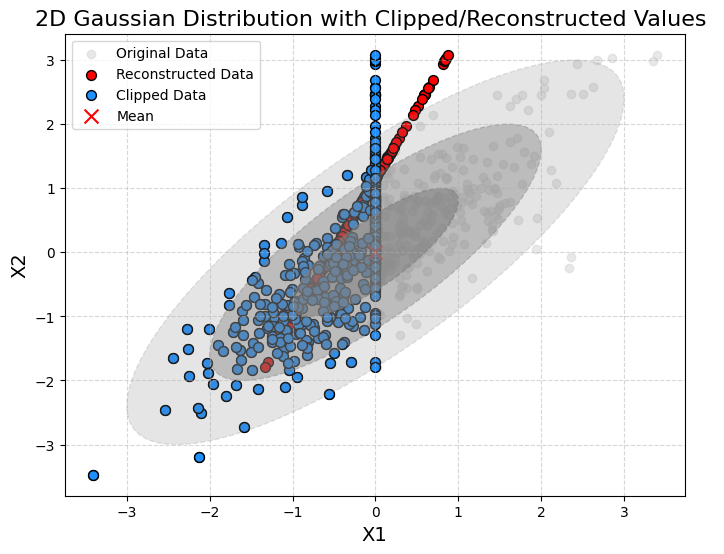

In [ ]:
X_gaussian_reconstructed = create_Xreconstructed(encoder, decoder, X_gaussian_clipped, X_gaussian_nan, 10000, device)


plt.figure(figsize=(8, 6))
plot_gaussian_distribution(X_gaussian, mean_v1, cov_v1, Xclipped=X_gaussian_clipped, Xreconstructed=X_gaussian_reconstructed)
plt.title("2D Gaussian Distribution with Clipped/Reconstructed Values ", fontsize=16)
plt.show()

### RMSE metric imputation :

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer




RMSE_model = imputationRMSE(X_gaussian, X_gaussian_reconstructed, S_gaussian)

if loss_choice == 'MIWAE':
    print("MIWAE, imputation RMSE", RMSE_model)
if loss_choice == 'notMIWAE':
    print("notMIWAE, imputation RMSE", RMSE_model)



estimator = RandomForestRegressor(n_estimators=100)
imp = IterativeImputer(estimator=estimator)
imp.fit(X_gaussian_nan)
Xrec_mf = imp.transform(X_gaussian_nan)
rmse_mf = imputationRMSE(X_gaussian, Xrec_mf, S_gaussian)
print("missForst imputation RMSE: ", rmse_mf)


imp = IterativeImputer(max_iter=100)
imp.fit(X_gaussian_nan)
Xrec_mice = imp.transform(X_gaussian_nan)
rmse_mice = imputationRMSE(X_gaussian, Xrec_mice, S_gaussian)
print("MICE, imputation RMSE", rmse_mice)

# KNN Imputation
imp_knn = KNNImputer(n_neighbors=5, weights='uniform')  # Use 5 nearest neighbors
imp_knn.fit(X_gaussian_nan)
Xrec_knn = imp_knn.transform(X_gaussian_nan)
rmse_knn = imputationRMSE(X_gaussian, Xrec_knn, S_gaussian)
print("KNN Imputation RMSE:", rmse_knn)

MIWAE, imputation RMSE 1.1533772506238185
missForst imputation RMSE:  1.329095195955708
MICE, imputation RMSE 1.154961523291478
KNN Imputation RMSE: 1.320448232764237


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### Ploting the learned p(s|x) :

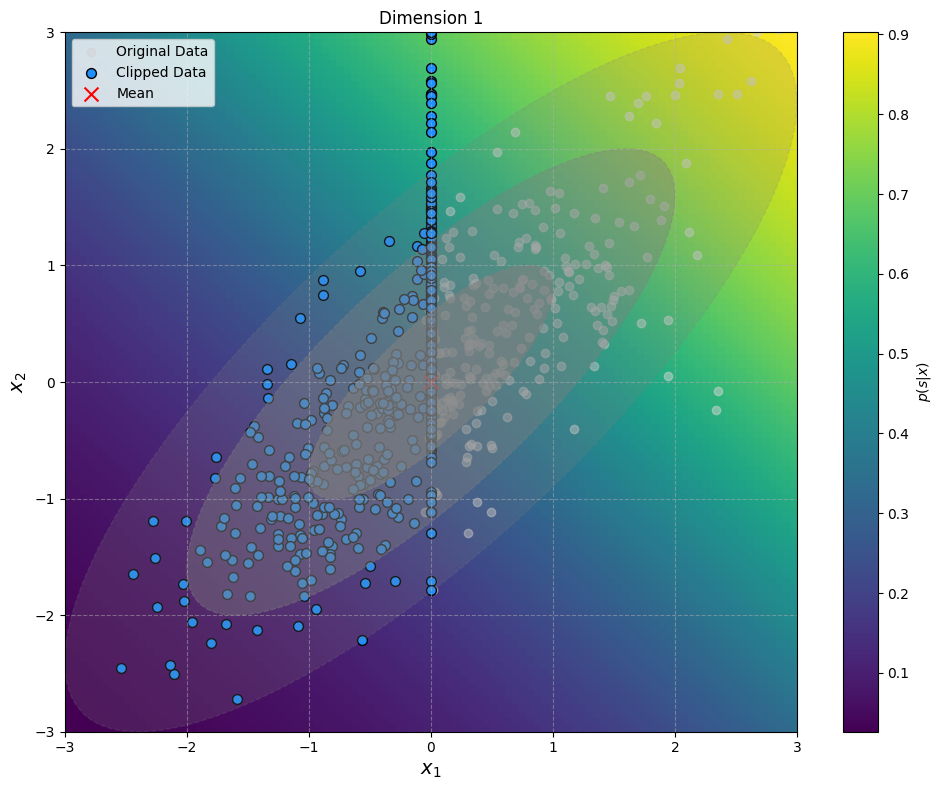

In [ ]:

# Create a 2D grid of values for x1 and x2
x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)

# Flatten the grid for computation
grid = np.stack([X1.ravel(), X2.ravel()], axis=1)  # Shape: (10000, 2)
grid_tensor = torch.tensor(grid, dtype=decoder.logits_layer[0].weight.dtype, device=device)
logits = decoder.logits_layer(grid_tensor)
probs = torch.sigmoid(logits)
probs = probs.reshape(X1.shape[0], X1.shape[1], -1).cpu().detach().numpy()  # Shape: (100, 100, D)


# Plot p(s|x) as a heatmap for each dimension
plt.figure(figsize=(10, 8))


d = 0
plot_gaussian_distribution(X_gaussian, mean_v1, cov_v1, Xclipped=X_gaussian_clipped)
plt.imshow(probs[:, :, d:d+1], extent=[-3, 3, -3, 3], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='$p(s|x)$')
plt.title(f'Dimension {d + 1}')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.tight_layout()
plt.show()


## Ring distribution clipped by angular sector


### Data creation
We generate a 2D ring distribution by sampling angles uniformly in $[0, 2\pi]$ and radius from a Gaussian distribution with mean 4.5 and variance $\sigma^2$.

In [ ]:
# ---- Generate ring-shaped data
def get_ring_distribution(n_samples, radius, sigma):

  # Generate random angles and radius
  angles = np.random.uniform(0, 2 * np.pi, n_samples)
  radiuses = np.random.normal(radius, sigma, n_samples)

  # Convert to Cartesian coordinates
  X_ring = np.zeros((n_samples, 2))
  X_ring[:, 0] = radiuses * np.cos(angles)
  X_ring[:, 1] = radiuses * np.sin(angles)

  return X_ring, radiuses, angles

n_samples = 1500
radius = 4.5
sigma = 0.5
X_ring, radiuses, angles = get_ring_distribution(n_samples, radius, sigma)

N, D = X_ring.shape
n_latent = D - 1
# Mask array for visualization
#S = ~np.isnan(Xz[:, 0])

### Missing values process definition
Keep only points within a specific angular sector

In [ ]:
angular_sector = (angles >= np.pi / 4) & (angles <= 3 * np.pi / 4)

# Apply clipping
clipped_mask = (radiuses > 10) | angular_sector


X_ring_nan = X_ring.copy()
X_ring_clipped = X_ring.copy()
X_ring_nan[:, :1][clipped_mask] = np.nan
X_ring_clipped[:, :1][clipped_mask] = 0

S_ring = np.array(~np.isnan(X_ring_nan), dtype=np.float32)

### Function to plot the ring distribution

In [ ]:
def plot_ring_distribution(X, radius, angles, Xclipped = None, Xreconstructed = None):

    # Plot the original ring data
    plt.scatter(X[:, 0], X[:, 1], c='lightgrey', alpha=0.5, label='Original Data')

    # Plot the reconstructed data
    if Xreconstructed is not None:
        plt.scatter(Xreconstructed[:, 0], Xreconstructed[:, 1], c='red', edgecolor='k', s=50, label='Reconstructed Data')

    # Plot the clipped data
    if Xclipped is not None:
        plt.scatter(Xclipped[:, 0], Xclipped[:, 1], c='dodgerblue', edgecolor='k', s=50, label='Clipped Data')



    # Add reference lines for the angular sector
    theta1, theta2 = np.pi / 4, 3 * np.pi / 4
    rad = 4.5
    line1 = [[0, rad * np.cos(theta1)], [0, rad * np.sin(theta1)]]
    line2 = [[0, rad * np.cos(theta1)], [0, rad * np.sin(theta1)]]
    line3 = [[0, rad * np.cos(theta2)], [0, rad * np.sin(theta2)]]

    plt.plot(line1[0], line1[1], 'r--', label='Angular Sector')
    plt.plot(line2[0], line2[1], 'r--')
    plt.plot(line3[0], line3[1], 'r--')

    # Final plot adjustments
    plt.xlabel("X1", fontsize=14)
    plt.ylabel("X2", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axis('equal')


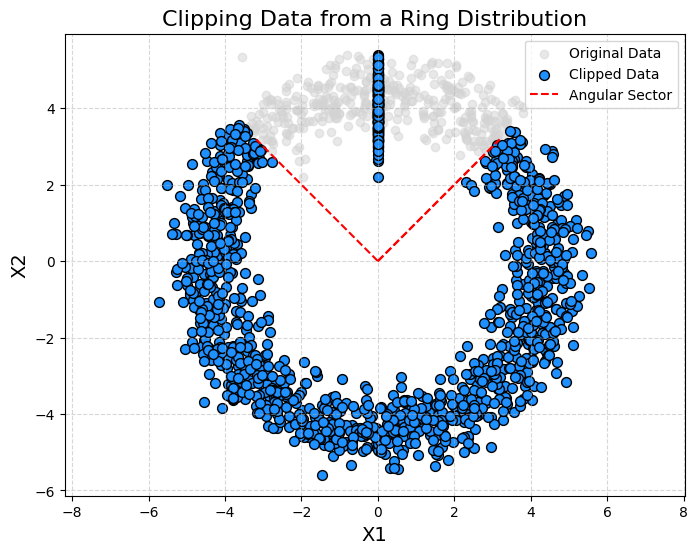

In [ ]:
plt.figure(figsize=(8, 6))
plot_ring_distribution(X_ring, radiuses, angles, Xclipped=X_ring_clipped)
plt.title("Clipping Data from a Ring Distribution", fontsize=16)
plt.show()

### Train a VAE over the clipped Ring Distribution

Iteration 0, Loss: 9.708345413208008
Iteration 100, Loss: 9.157390594482422
Iteration 200, Loss: 9.012950897216797
Iteration 300, Loss: 8.881937026977539
Iteration 400, Loss: 8.75839614868164
Iteration 500, Loss: 8.636580467224121
Iteration 600, Loss: 8.520954132080078
Iteration 700, Loss: 8.407612800598145
Iteration 800, Loss: 8.299102783203125
Iteration 900, Loss: 8.193296432495117
Iteration 1000, Loss: 8.091849327087402
Iteration 1100, Loss: 7.996658802032471
Iteration 1200, Loss: 7.902871131896973
Iteration 1300, Loss: 7.811990737915039
Iteration 1400, Loss: 7.724393367767334
Iteration 1500, Loss: 7.6383280754089355
Iteration 1600, Loss: 7.554311752319336
Iteration 1700, Loss: 7.4763503074646
Iteration 1800, Loss: 7.398497104644775
Iteration 1900, Loss: 7.323025226593018
Iteration 2000, Loss: 7.2501654624938965
Iteration 2100, Loss: 7.176249980926514
Iteration 2200, Loss: 7.1096625328063965
Iteration 2300, Loss: 7.043329238891602
Iteration 2400, Loss: 6.975027084350586
Iteration 25

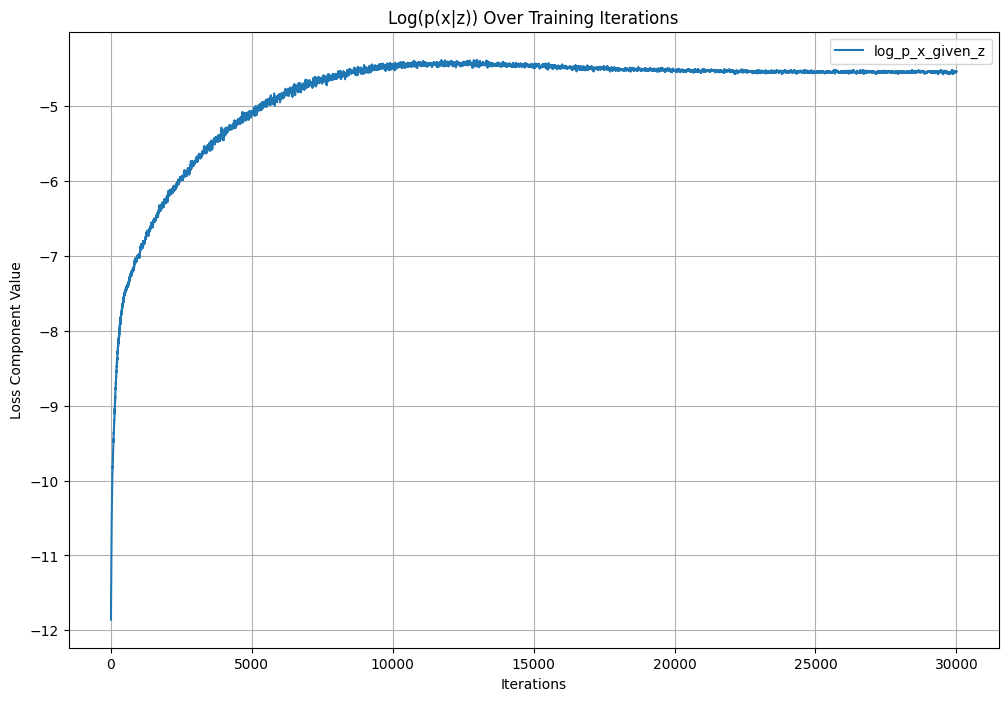

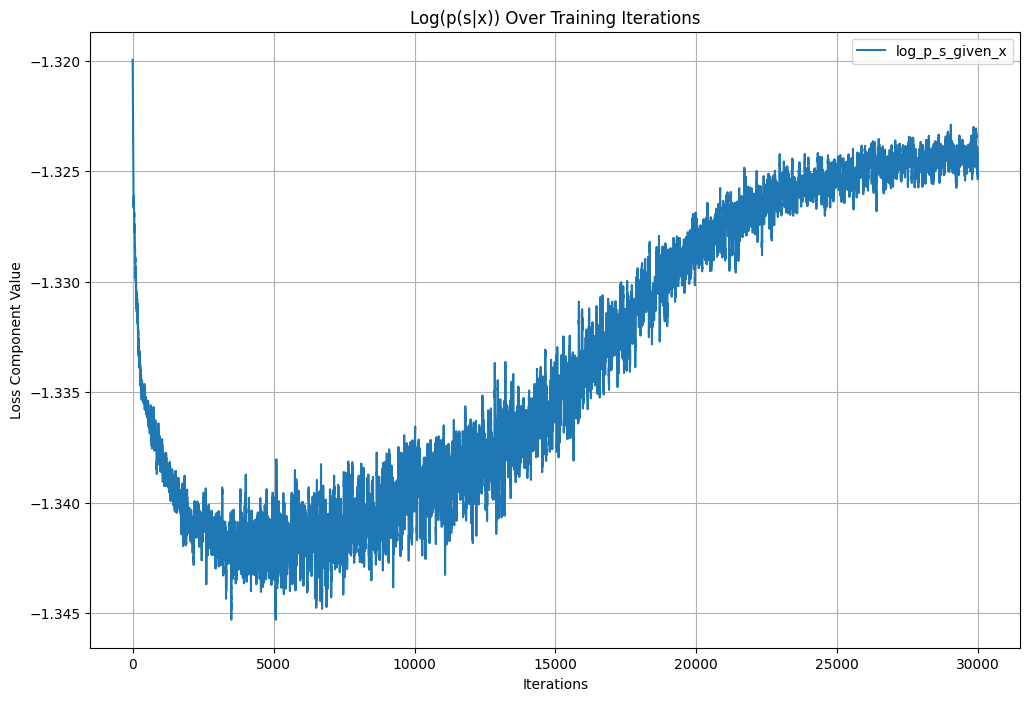

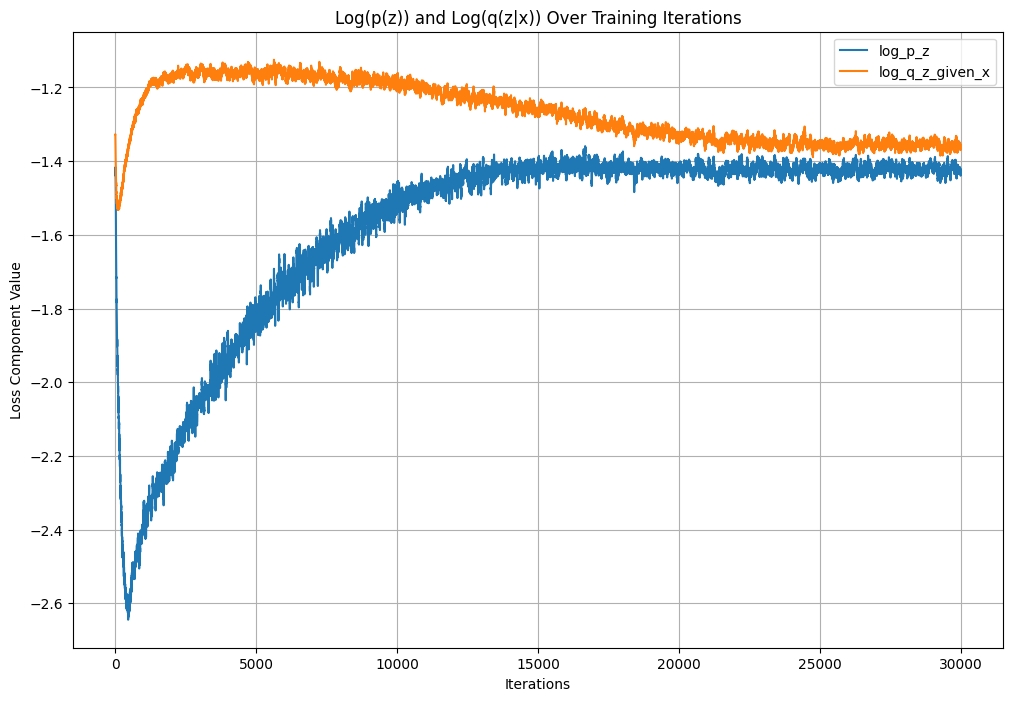

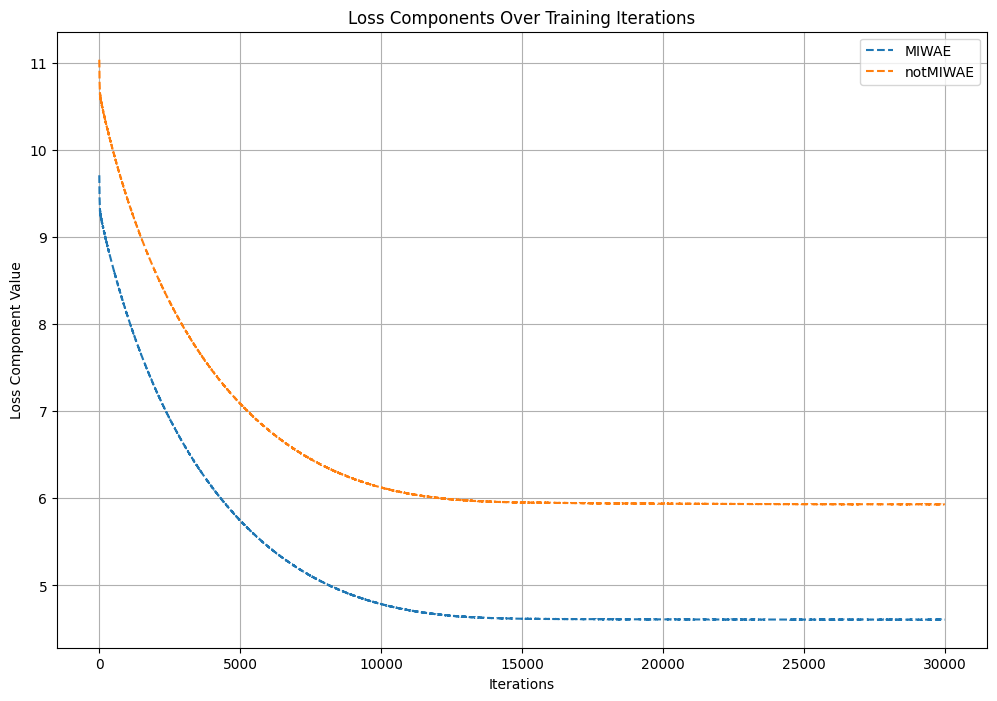

In [ ]:
N, D = X_ring.shape
n_latent = D - 1
n_hidden = 128
n_samples = 20
max_iter = 30000
batch_size = 32

encoder = Encoder(D, n_hidden, n_latent)
decoder = Decoder(n_latent, D)
loss_choice = 'MIWAE' # 'notMIWAE' or 'MIWAE'
train_model(encoder, decoder, X_ring_clipped, S_ring, sample_latent, compute_loss, max_iter, lr=0.0001, device = device, n_pl=n_samples)

### Reconstrut and plot

0 / 1500
100 / 1500
200 / 1500
300 / 1500
400 / 1500
500 / 1500
600 / 1500
700 / 1500
800 / 1500
900 / 1500
1000 / 1500
1100 / 1500
1200 / 1500
1300 / 1500
1400 / 1500


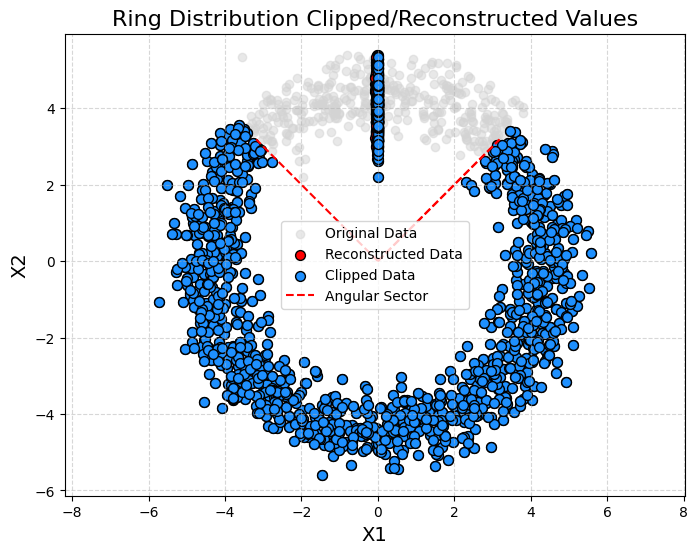

In [ ]:
X_ring_reconstructed = create_Xreconstructed(encoder, decoder, X_ring_clipped, X_ring_nan, 10000, device)

plt.figure(figsize=(8, 6))
plot_ring_distribution(X_ring, radiuses, angles, Xclipped=X_ring_clipped, Xreconstructed=X_ring_reconstructed)
plt.title("Ring Distribution Clipped/Reconstructed Values", fontsize=16)
plt.show()

### RMSE metric computation

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer



RMSE_model = imputationRMSE(X_ring, X_ring_reconstructed, S_ring)

if loss_choice == 'MIWAE':
    print("MIWAE, imputation RMSE", RMSE_model)
if loss_choice == 'notMIWAE':
    print("notMIWAE, imputation RMSE", RMSE_model)



estimator = RandomForestRegressor(n_estimators=100)
imp = IterativeImputer(estimator=estimator)
imp.fit(X_ring_nan)
Xrec_mf = imp.transform(X_ring_nan)
rmse_mf = imputationRMSE(X_ring, Xrec_mf, S_ring)
print("missForst imputation RMSE: ", rmse_mf)


imp = IterativeImputer(max_iter=100)
imp.fit(X_ring_nan)
Xrec_mice = imp.transform(X_ring_nan)
rmse_mice = imputationRMSE(X_ring, Xrec_mice, S_ring)
print("MICE, imputation RMSE", rmse_mice)

# KNN Imputation
imp_knn = KNNImputer(n_neighbors=5, weights='uniform')  # Use 5 nearest neighbors
imp_knn.fit(X_ring_nan)
Xrec_knn = imp_knn.transform(X_ring_nan)
rmse_knn = imputationRMSE(X_ring, Xrec_knn, S_ring)
print("KNN Imputation RMSE:", rmse_knn)

MIWAE, imputation RMSE 1.9772461451071166
missForst imputation RMSE:  4.0344779492061615
MICE, imputation RMSE 1.9748379775973917
KNN Imputation RMSE: 3.0464045438662035


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### Ploting p(s|x):

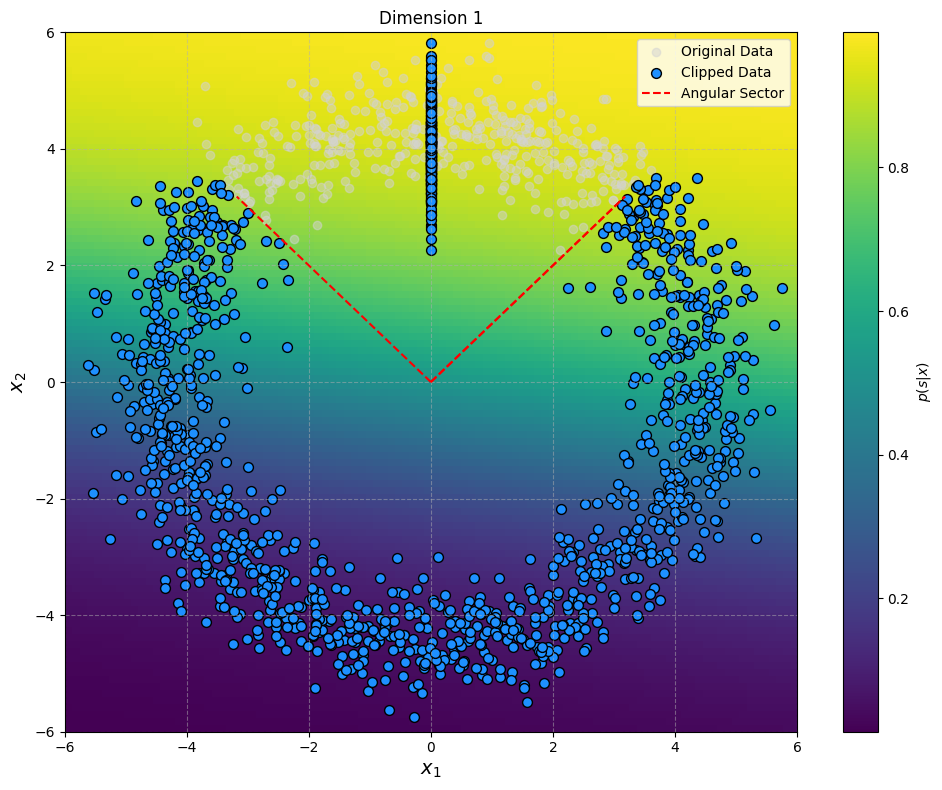

In [ ]:

# Create a 2D grid of values for x1 and x2
x1 = np.linspace(-6, 6, 100)
x2 = np.linspace(-6, 6, 100)
X1, X2 = np.meshgrid(x1, x2)

# Flatten the grid for computation
grid = np.stack([X1.ravel(), X2.ravel()], axis=1)  # Shape: (10000, 2)
grid_tensor = torch.tensor(grid, dtype=decoder.logits_layer[0].weight.dtype, device=device)
logits = decoder.logits_layer(grid_tensor)
probs = torch.sigmoid(logits)
probs = probs.reshape(X1.shape[0], X1.shape[1], -1).cpu().detach().numpy()  # Shape: (100, 100, D)


# Plot p(s|x) as a heatmap for each dimension
plt.figure(figsize=(10, 8))
d = 0
plot_ring_distribution(X_ring, radiuses, angles, Xclipped=X_ring_clipped)
plt.imshow(probs[:, :, d:d+1], extent=[-6, 6, -6, 6], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='$p(s|x)$')
plt.title(f'Dimension {d + 1}')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.tight_layout()
plt.show()


# Example with images : MNIST dataset

In [ ]:
import torch
import torch.utils.data
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a data loader for the training set
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Example: Apply the missing mask to a single batch
data_iter = iter(train_loader)
images, labels = next(data_iter)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:10<00:00, 902kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.21MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



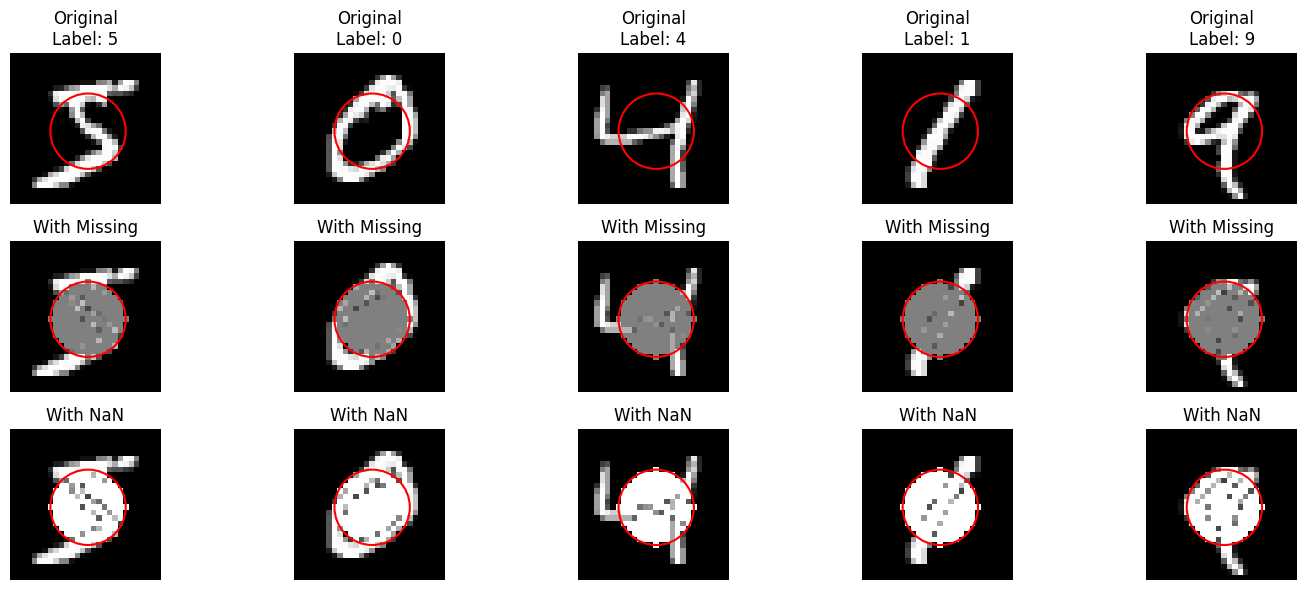

In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Load MNIST dataset without using DataLoader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Convert all images into a single numpy array
images = []
labels = []

for image, label in train_dataset:
    images.append(image.numpy()[0])  # Convert to numpy and flatten to (28, 28)
    labels.append(label)

# Convert the images and labels into numpy arrays
images = np.stack(images)  # Shape: (num_images, 28, 28)
labels = np.array(labels)  # Shape: (num_images,)

# Function to create a circular mask for missing data
def create_missing_mask(image, radius=7, center=None):
    """
    Create a circular mask for missing data in an image.
    Args:
        image (array): The image array of shape (28, 28).
        radius (int): The radius of the circle.
        center (tuple): The center (x, y) of the circle. If None, use the image center.
    Returns:
        mask (array): A binary mask with 1 for missing values and 0 for observed values.
    """
    # Default center is the middle of the image
    if center is None:
        center = (image.shape[0] // 2, image.shape[1] // 2)

    # Create a grid of coordinates
    y, x = np.ogrid[:image.shape[0], :image.shape[1]]
    mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2  # Circle equation

    return mask

# Function to apply the mask and threshold to images and generate S tensor
def apply_mask_to_images(images, labels, radius=7, threshold=0.5):
    images_with_missing = []
    missing_masks = []
    images_nan = []  # Array to store images with NaN values

    # Apply the circular mask and threshold to each image
    for image in images:
        mask = create_missing_mask(image, radius=radius)

        # Identify pixels within the mask and above the threshold
        threshold_mask = (np.abs(image) > threshold) & mask

        missing_masks.append(threshold_mask.astype(int))  # Convert boolean mask to binary 0s and 1s

        # Apply the mask (set pixels in the circular region above threshold to zero)
        masked_image = image.copy()
        masked_image[threshold_mask] = 0  # Set the pixels meeting criteria to zero
        images_with_missing.append(masked_image)

        # Create the images with NaN where the mask and threshold are satisfied
        image_nan = image.copy()
        image_nan[threshold_mask] = np.nan  # Set the pixels meeting criteria to NaN
        images_nan.append(image_nan)

    # Convert the images with missing values and the mask to numpy arrays
    images_with_missing = np.array(images_with_missing)
    missing_mask = np.array(~np.isnan(images_nan), dtype=np.float32)
    images_nan = np.array(images_nan)

    return images_with_missing, missing_mask, images_nan

import matplotlib.patches as patches

# Example to visualize and test with a few images
def visualize_images_with_mask(images, labels, num_images_to_plot=5, radius=7, threshold=0.5):
    images_with_missing, S_tensor, images_nan = apply_mask_to_images(images, labels, radius, threshold)

    # Plot the masked images
    fig, axes = plt.subplots(3, num_images_to_plot, figsize=(15, 6))
    for i in range(num_images_to_plot):
        center = (images[i].shape[0] // 2, images[i].shape[1] // 2)  # Default to image center

        # Plot original image
        axes[0, i].imshow(images[i], cmap='gray')
        axes[0, i].set_title(f"Original\nLabel: {labels[i]}")
        axes[0, i].axis('off')

        # Add a circle to highlight the clipping zone
        circle = patches.Circle(center, radius, linewidth=1.5, edgecolor='red', facecolor='none')
        axes[0, i].add_patch(circle)

        # Plot image with missing data
        axes[1, i].imshow(images_with_missing[i], cmap='gray')
        axes[1, i].set_title("With Missing")
        axes[1, i].axis('off')

        # Add a circle to highlight the clipping zone
        circle = patches.Circle(center, radius, linewidth=1.5, edgecolor='red', facecolor='none')
        axes[1, i].add_patch(circle)

        # Plot image with NaN values
        axes[2, i].imshow(images_nan[i], cmap='gray')
        axes[2, i].set_title("With NaN")
        axes[2, i].axis('off')

        # Add a circle to highlight the clipping zone
        circle = patches.Circle(center, radius, linewidth=1.5, edgecolor='red', facecolor='none')
        axes[2, i].add_patch(circle)

    plt.tight_layout()
    plt.show()


# Visualize some images with missing data
visualize_images_with_mask(images, labels, num_images_to_plot=5, radius=7, threshold=0.5)


In [ ]:
images.shape

(60000, 28, 28)

In [ ]:
images_with_missing, missing_mask, images_nan = apply_mask_to_images(images, labels, radius=5)
print(images_with_missing.shape)
print(missing_mask.shape)
print(images_nan.shape)

(60000, 28, 28)
(60000, 28, 28)
(60000, 28, 28)


In [ ]:
# Assuming images_with_missing_for_train_shuffled has shape (20000, 28, 28)
images_flat = images_with_missing[:2000].reshape(images_with_missing[:2000].shape[0], -1)  # Shape becomes (20000, 784)

# Assuming mask_with_missing_for_train_shuffled has shape (20000, 28, 28)
mask_flat = missing_mask[:2000].reshape(missing_mask[:2000].shape[0], -1)  # Shape becomes (20000, 784)


Iteration 0, Loss: 1110.7918701171875
Iteration 100, Loss: 657.576904296875
Iteration 200, Loss: 588.0918579101562
Iteration 300, Loss: 527.23974609375
Iteration 400, Loss: 470.9073486328125
Iteration 500, Loss: 417.2898864746094
Iteration 600, Loss: 362.5940856933594
Iteration 700, Loss: 307.22607421875
Iteration 800, Loss: 254.48106384277344
Iteration 900, Loss: 207.83331298828125


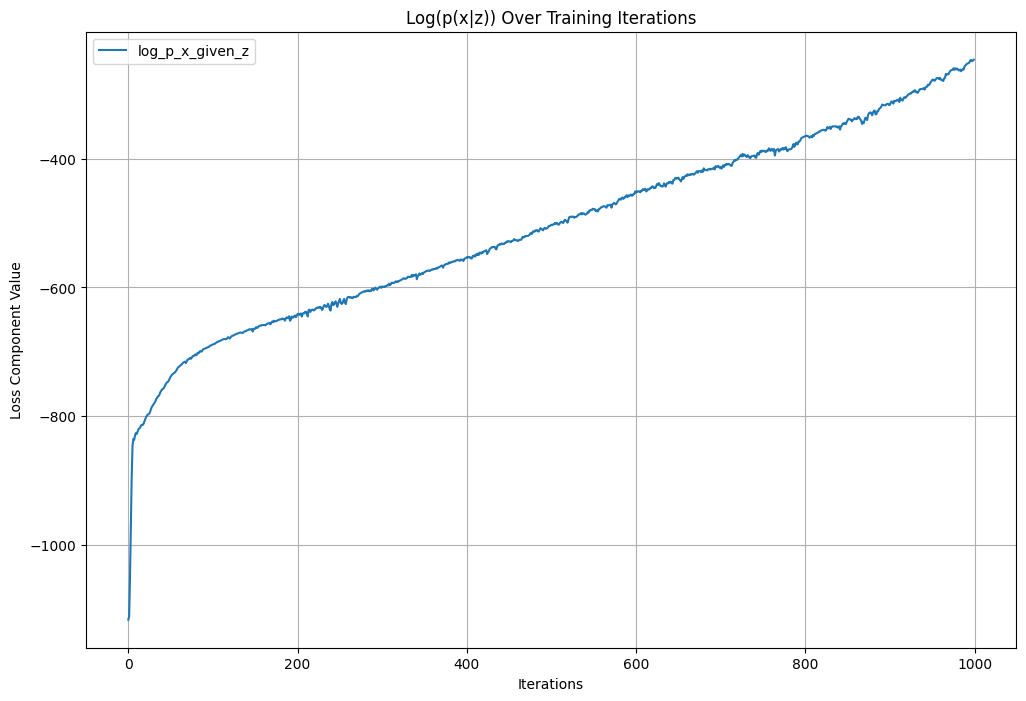

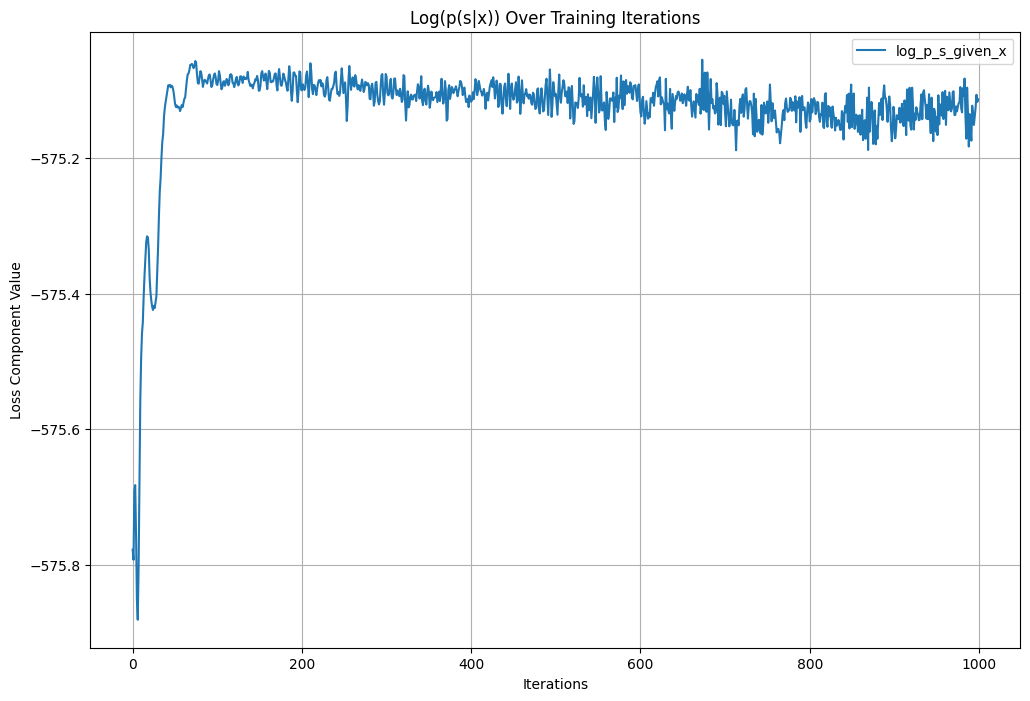

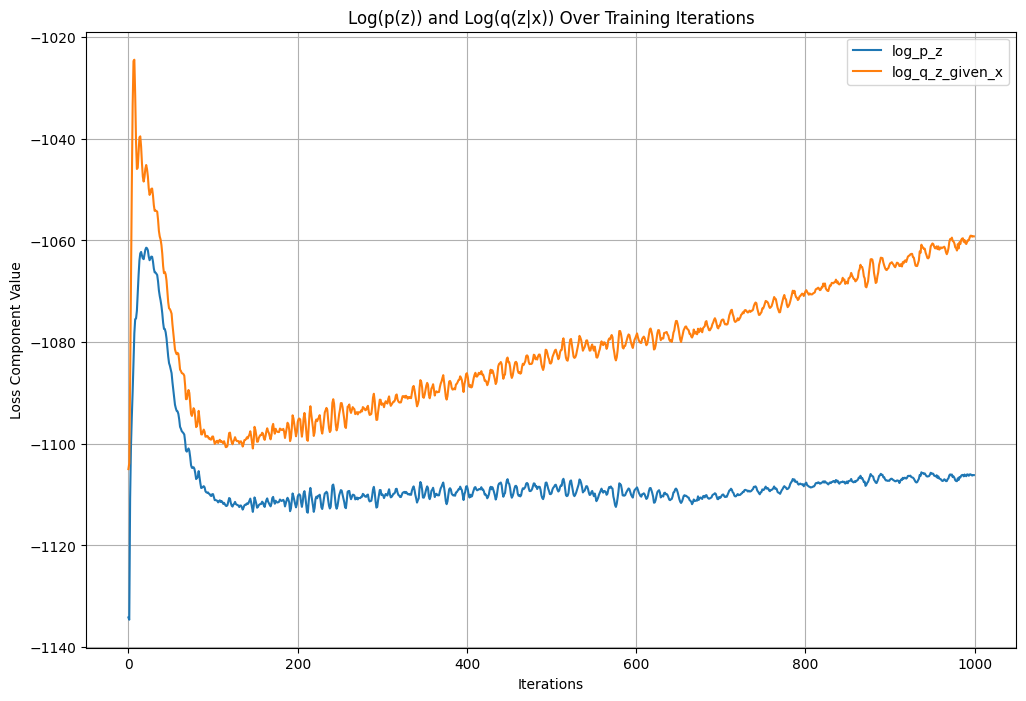

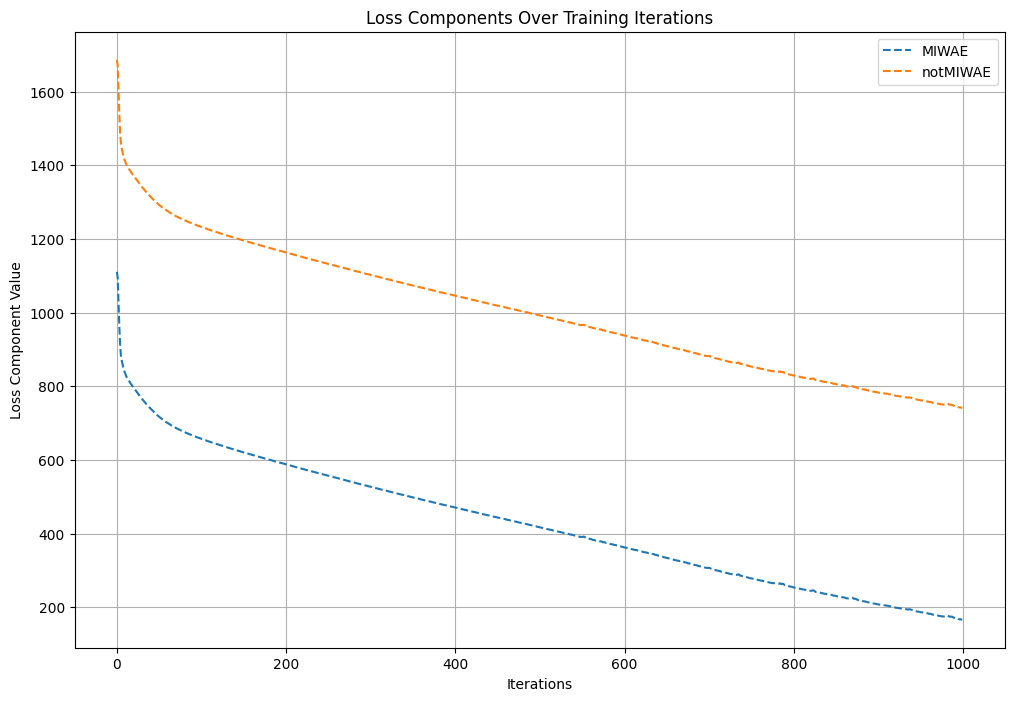

In [ ]:
# Parameters for training
D = 28 * 28  # MNIST image size: 28x28
n_latent = D - 1
n_hidden = 128
n_samples = 20
max_iter = 1000
batch_size = 64

encoder = Encoder(D, n_hidden, n_latent)
decoder = Decoder(n_latent, D)
loss_choice = 'MIWAE' # 'notMIWAE' or 'MIWAE'
train_model(encoder, decoder, images_flat, mask_flat, sample_latent, compute_loss, max_iter, device = device, n_pl=n_samples, loss_choice=loss_choice)

In [ ]:
# Assuming images_with_missing_for_train_shuffled has shape (20000, 28, 28)
images_with_missing_flat = images_flat  # Shape becomes (20000, 784)

# Assuming images_with_missing_for_train_shuffled has shape (20000, 28, 28)
images_nan_flat = images_nan[:2000].reshape(images_nan[:2000].shape[0], -1)

original_image = images[:2000]
# Assuming mask_with_missing_for_train_shuffled has shape (20000, 28, 28)
original_image_flat = original_image.reshape(original_image.shape[0], -1)  # Shape becomes (20000, 784)

In [ ]:
Xmix = create_Xreconstructed(encoder, decoder, images_with_missing_flat, images_nan_flat, 1000, device)
Xmix_reshaped = Xmix.reshape(Xmix.shape[0], 28, 28)

<ipython-input-8-19f538866513>:71: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  xm = torch.sum( (mu.T * wl.T).T, axis=1)


0 / 2000
100 / 2000
200 / 2000
300 / 2000
400 / 2000
500 / 2000
600 / 2000
700 / 2000
800 / 2000
900 / 2000
1000 / 2000
1100 / 2000
1200 / 2000
1300 / 2000
1400 / 2000
1500 / 2000
1600 / 2000
1700 / 2000
1800 / 2000
1900 / 2000


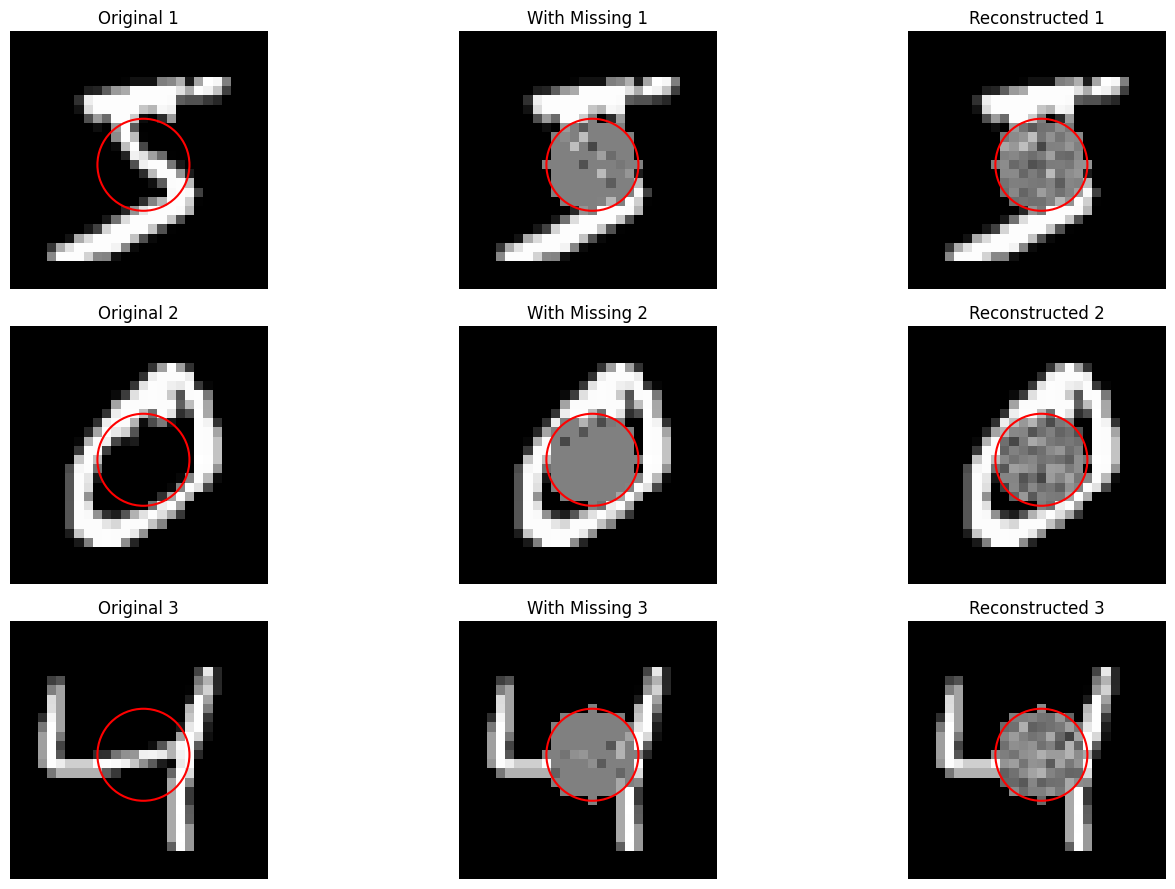

In [ ]:
# Plot the masked images
images_with_missing = images_with_missing
reconstructed_image = Xmix_reshaped


import matplotlib.patches as patches

# Plot the masked images
num_images_to_plot = 3
fig, axes = plt.subplots(num_images_to_plot, 3, figsize=(15, 3 * num_images_to_plot))  # Create subplots for triplets

# Define the center and radius of the circle
radius = 5  # Adjust as needed
center = (original_image.shape[1] // 2, original_image.shape[2] // 2)  # Center of the image

for i in range(num_images_to_plot):
    # Plot original image
    axes[i, 0].imshow(original_image[i], cmap='gray')
    axes[i, 0].set_title(f"Original {i+1}")
    axes[i, 0].axis('off')

    # Add a circle to the original image
    circle = patches.Circle(center, radius, linewidth=1.5, edgecolor='red', facecolor='none')
    axes[i, 0].add_patch(circle)

    # Plot image with missing values
    axes[i, 1].imshow(images_with_missing[i], cmap='gray')
    axes[i, 1].set_title(f"With Missing {i+1}")
    axes[i, 1].axis('off')

    # Add a circle to the missing values image
    circle = patches.Circle(center, radius, linewidth=1.5, edgecolor='red', facecolor='none')
    axes[i, 1].add_patch(circle)

    # Plot reconstructed image
    axes[i, 2].imshow(reconstructed_image[i], cmap='gray')
    axes[i, 2].set_title(f"Reconstructed {i+1}")
    axes[i, 2].axis('off')

    # Add a circle to the reconstructed image
    circle = patches.Circle(center, radius, linewidth=1.5, edgecolor='red', facecolor='none')
    axes[i, 2].add_patch(circle)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer


RMSE_model = imputationRMSE(original_image_flat, Xmix, mask_flat)

if loss_choice == 'MIWAE':
    print("MIWAE, imputation RMSE", RMSE_model)
if loss_choice == 'notMIWAE':
    print("notMIWAE, imputation RMSE", RMSE_model)


'''
estimator = RandomForestRegressor(n_estimators=10)
imp = IterativeImputer(estimator=estimator)
imp.fit(images_nan_flat)
Xrec_mf = imp.transform(images_nan_flat)
rmse_mf = imputationRMSE(original_image_flat, Xrec_mf, mask_flat)
print("missForst imputation RMSE: ", rmse_mf)
'''


imp = IterativeImputer(max_iter=1)
imp.fit(images_nan_flat)
Xrec_mice = imp.transform(images_nan_flat)
rmse_mice = imputationRMSE(original_image_flat, Xrec_mice, mask_flat)
print("MICE, imputation RMSE", rmse_mice)


# KNN Imputation
imp_knn = KNNImputer(n_neighbors=5, weights='uniform')  # Use 5 nearest neighbors
imp_knn.fit(images_nan_flat)
Xrec_knn = imp_knn.transform(images_nan_flat)
rmse_knn = imputationRMSE(original_image_flat, Xrec_knn, mask_flat)
print("KNN Imputation RMSE:", rmse_knn)

MIWAE, imputation RMSE 0.92858344


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


MICE, imputation RMSE 0.94518864
KNN Imputation RMSE: 0.93535286


# New architecture :


1. **Deeper Architectures**: Added extra layers in both encoder and decoder, which enables learning more complex patterns.
2. **Batch Normalization**: Added to each hidden layer to stabilize training and improve convergence.
3. **LeakyReLU Activation**: Replaces `tanh` with `LeakyReLU` for a more flexible non-linearity that mitigates the vanishing gradient problem.
4. **Dropout Regularization**: Helps prevent overfitting, especially useful in smaller datasets.
5. **Learnable Log Standard Deviation**: Made `logstd` a learnable parameter for the decoder, improving its flexibility.


In [ ]:
class EncoderAugmented(nn.Module):
    def __init__(self, D, n_hidden, n_latent):
        super(EncoderAugmented, self).__init__()
        # Define a deeper architecture for the encoder
        self.l_enc1 = nn.Linear(D, n_hidden)
        self.l_enc2 = nn.Linear(n_hidden, n_hidden)
        self.l_enc3 = nn.Linear(n_hidden, n_hidden)  # New additional layer

        # Define output layers for mean and log standard deviation
        self.q_mu = nn.Linear(n_hidden, n_latent)
        self.q_logstd = nn.Linear(n_hidden, n_latent)

        # Regularization and activation functions
        self.dropout = nn.Dropout(0.2)  # Dropout for regularization
        self.batch_norm = nn.BatchNorm1d(n_hidden)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.activation(self.batch_norm(self.l_enc1(x)))
        x = self.dropout(x)
        x = self.activation(self.batch_norm(self.l_enc2(x)))
        x = self.dropout(x)
        x = self.activation(self.batch_norm(self.l_enc3(x)))

        q_mu = self.q_mu(x)
        q_logstd = torch.clamp(self.q_logstd(x), -10, 10)
        return q_mu, q_logstd


class DecoderAugmented(nn.Module):
    def __init__(self, n_latent, D, n_hidden):
        super(DecoderAugmented, self).__init__()

        # Define decoder layers
        self.l_dec1 = nn.Linear(n_latent, n_hidden)
        self.l_dec2 = nn.Linear(n_hidden, n_hidden)
        self.l_dec3 = nn.Linear(n_hidden, D)  # Directly output D dimensions for mu

        # Log standard deviation as a learnable parameter
        self.logstd = nn.Parameter(torch.zeros(D), requires_grad=True)

        # Output layer for Bernoulli logits
        self.logits_layer = nn.Linear(D, D)

        # Activation and dropout
        self.dropout = nn.Dropout(0.2)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, l_z, x_pl, s_pl):
        # Pass through decoder layers
        x = self.activation(self.l_dec1(l_z))
        x = self.dropout(x)
        x = self.activation(self.l_dec2(x))
        x = self.dropout(x)
        mu = self.l_dec3(x)  # Directly obtain mu

        # Predict the mean and standard deviation for p(x|z)
        p_x_given_z = Normal(mu, torch.exp(self.logstd))

        # Mix observed and imputed values and compute logits for p(s|x)
        l_out_mixed = mu * (1 - s_pl.unsqueeze(1)) + (x_pl * s_pl).unsqueeze(1)
        logits = self.logits_layer(l_out_mixed)
        p_s_given_x = Bernoulli(logits=logits)

        return p_x_given_z, p_s_given_x, l_out_mixed



In [ ]:
n_latent = D - 1
n_hidden = 128
n_samples = 20
max_iter = 30000
batch_size = 16

encoder_augmented = EncoderAugmented(D, n_hidden, n_latent)
decoder_augmented = DecoderAugmented(n_latent, D, n_hidden)
loss_choice = 'notMIWAE' # 'notMIWAE' or 'MIWAE'
train_model(encoder_augmented, decoder_augmented, X_gaussian_clipped, S_gaussian, sample_latent, compute_loss, max_iter, lr=1e-4, device = device, n_pl=n_samples)



In [ ]:
Xmix = create_Xreconstructed(encoder, decoder, X_gaussian_clipped, X_gaussian_nan, 10000, device)
RMSE_model = np.sqrt(np.sum((X_gaussian - Xmix) ** 2 * (1 - S_gaussian)) / np.sum(1 - S_gaussian))
print("notMIWAE, imputation RMSE", RMSE_model)

In [ ]:
# Function to generate Xmix, combining observed and imputed values
def create_Xmix_augmented(encoder,decoder, Xorg, Xnan, L, device, loss_choice = 'MIWAE'):
    """
    Function to create Xmix, a data matrix with observed values preserved
    and missing values filled with imputed data.

    Args:
        sess: TensorFlow session for evaluating the computational graph.
        Xorg: Original data matrix with no missing values.
        Xnan: Data matrix with NaN values for missing entries.
        L: Number of importance sampling points for the latent space.

    Returns:
        Xmix: A matrix where observed values are kept, and missing values are imputed.

    """
    # Put encoder and decoder in evaluation mode
    encoder.eval()
    decoder.eval()

    N = len(Xorg)  # Total number of samples

    # Replace NaNs in Xnan with 0s to initialize imputation
    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0

    # Create binary mask S: 1 for observed values, 0 for missing values
    S = np.array(~np.isnan(Xnan), dtype=np.float32)

    # Define a helper softmax function for normalizing importance weights
    def softmax(x):
        e_x = torch.exp(x - torch.max(x, dim=1, keepdim=True)[0])
        return e_x / e_x.sum(dim=1, keepdim=True)

    # Helper function to compute imputation for a single sample
    def imp(xz, s, L):
        # Convert inputs to PyTorch tensors
        xz_tensor = torch.tensor(xz, dtype=torch.float32).to(device)
        s_tensor = torch.tensor(s, dtype=torch.float32).to(device)
        # Forward pass through encoder
        q_mu, q_logstd = encoder(xz_tensor)
        l_z, q_z = sample_latent(q_mu, q_logstd, L)

        # Forward pass through decoder with latent samples and mask
        p_x_given_z, p_s_given_x, l_out_mixed = decoder(l_z, xz_tensor, s_tensor)

        # Log p(x|z)
        log_p_x_given_z = torch.sum((s_tensor.unsqueeze(1) * p_x_given_z.log_prob(xz_tensor.unsqueeze(1))), dim=-1)

        # Log q(z|x)
        q_z2 = Normal(q_z.loc.unsqueeze(1), q_z.scale.unsqueeze(1))
        log_q_z_given_x = torch.sum(q_z2.log_prob(l_z), dim=-1)

        # Log p(z)
        prior = Normal(0.0, 1.0)
        log_p_z = torch.sum(prior.log_prob(l_z), dim=-1)



        # Calculate importance weights with softmax
        if loss_choice == 'notMIWAE':
            # Log p(s|x)
            log_p_s_given_x = torch.sum(p_s_given_x.log_prob(s_tensor.unsqueeze(1)), dim=-1)

            wl = softmax(log_p_x_given_z + log_p_s_given_x + log_p_z - log_q_z_given_x)
        else:
            wl = softmax(log_p_x_given_z + log_p_z - log_q_z_given_x)

        a = decoder.activation(decoder.l_dec1(l_z))
        a = decoder.dropout(a)
        a = decoder.activation(decoder.l_dec2(a))
        a = decoder.dropout(a)
        mu = decoder.l_dec3(a)  # Directly obtain mu
        # Compute imputed values by mixing predicted means (_mu) using weights (wl)
        xm = torch.sum( (mu.T * wl.T).T, axis=1)

        # Combine observed and imputed values to form xmix
        xmix = xz_tensor + xm * (1 - s_tensor)

        return xmix.cpu().detach().numpy()

    # Initialize matrix to store final Xmix values
    Xmix = np.zeros_like(Xorg)

    # Loop over each sample to apply imputation
    for i in range(N):
        # Select the current sample and corresponding mask
        xz = Xz[i, :][None, :]
        s = S[i, :][None, :]

        # Generate imputed values for the sample
        xmix = imp(xz, s, L)

        # Store the result in Xmix
        Xmix[i, :] = xmix

        # Print progress every 100 samples
        if i % 100 == 0:
            print(f'{i} / {N}')

    return Xmix


In [ ]:
Xmix = create_Xmix_augmented(encoder_augmented, decoder_augmented, X_gaussian_clipped, X_gaussian_nan, 10000, device)
RMSE_model = np.sqrt(np.sum((X_gaussian - Xmix) ** 2 * (1 - S_gaussian)) / np.sum(1 - S_gaussian))
print("notMIWAE, imputation RMSE for augmented version", RMSE_model)

# Search for best hyperparamters using Weights and Biases Sweep

In [ ]:
import wandb
import matplotlib.pyplot as plt
import torch.optim as optim
import torch

def train_model_wandb(
    encoder,
    decoder,
    Xz,
    S,
    sample_latent,
    compute_loss,
    max_iter=1000,
    lr=1e-3,
    n_pl=10,
    device=torch.device("cpu"),
    loss_choice='MIWAE'
):
    # Initialize W&B logging
    wandb.init(project="imputation_model_training")
    config = wandb.config

    encoder.to(device)
    decoder.to(device)

    optimizer = optim.Adam(
        list(encoder.parameters()) + list(decoder.parameters()) + [decoder.logstd],
        lr=lr
    )

    Xz_tensor = torch.tensor(Xz, dtype=torch.float32, device=device)
    S_tensor = torch.tensor(S, dtype=torch.float32, device=device)

    # Initialize lists to store loss components
    log_p_x_list = []
    log_p_s_list = []
    log_p_z_list = []
    log_q_z_list = []
    MIWAE_list = []
    notMIWAE_list = []

    for i in range(max_iter):
        q_mu, q_logstd = encoder(Xz_tensor)
        l_z, q_z = sample_latent(q_mu, q_logstd, n_pl)

        p_x_given_z, p_s_given_x, l_out_mixed = decoder(l_z, Xz_tensor, S_tensor)

        MIWAE, notMIWAE, log_p_x_given_z, log_p_s_given_x, log_p_z, log_q_z_given_x = compute_loss(
            Xz_tensor, S_tensor, q_z, l_z, p_x_given_z, p_s_given_x, n_pl
        )

        # Choose the loss based on the specified loss_choice
        if loss_choice == 'MIWAE':
            loss = -MIWAE
        elif loss_choice == 'notMIWAE':
            loss = -notMIWAE

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss components
        log_p_x_list.append(log_p_x_given_z.mean().item())
        log_p_s_list.append(log_p_s_given_x.mean().item() if log_p_s_given_x is not None else 0)
        log_p_z_list.append(log_p_z.mean().item())
        log_q_z_list.append(log_q_z_given_x.mean().item())
        MIWAE_list.append(-MIWAE.item())
        notMIWAE_list.append(-notMIWAE.item())

        # Log metrics to W&B
        wandb.log({
            "iteration": i,
            "log_p_x_given_z": log_p_x_given_z.mean().item(),
            "log_p_s_given_x": log_p_s_given_x.mean().item() if log_p_s_given_x is not None else 0,
            "log_p_z": log_p_z.mean().item(),
            "log_q_z_given_x": log_q_z_given_x.mean().item(),
            "MIWAE": -MIWAE.item(),
            "notMIWAE": -notMIWAE.item(),
            "loss": loss.item()
        })


In [ ]:
import wandb
import numpy as np
import torch

# Define the sweep configuration
sweep_config = {
    'method': 'bayes',  # Search strategy: 'bayes', 'random', or 'grid'
    'metric': {
        'name': 'RMSE_model',  # The metric to optimize
        'goal': 'minimize'
    },
    'parameters': {
        'lr': {
            'values': [1e-4, 1e-5]
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'n_samples': {
            'values': [1, 2.5, 5, 10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000]
        },
        'max_iter': {
            'values': [10000]
        },
        'loss_choice': {
            'values': ['MIWAE', 'notMIWAE']
        },
        'n_hidden': {
            'values': [2, 4, 8, 16, 32, 64, 128, 256, 512]
        }
    }
}

# Define the training function
def train_model_with_wandb():
    wandb.init()  # Initialize a new W&B run
    config = wandb.config  # Access hyperparameters from the sweep

    # Initialize model components with hyperparameters from the sweep
    encoder = Encoder(D, config.n_hidden, n_latent)
    decoder = Decoder(n_latent, D)

    # Train the model with the provided hyperparameters
    train_model_wandb(
        encoder=encoder,
        decoder=decoder,
        Xz=X_gaussian_clipped,
        S=S_gaussian,
        sample_latent=sample_latent,
        compute_loss=compute_loss,
        max_iter=config.max_iter,
        lr=config.lr,
        n_pl=config.n_samples,
        loss_choice=config.loss_choice,
        device=device
    )

    # Generate imputed data using the trained model
    Xmix = create_Xreconstructed(encoder, decoder, X_gaussian_clipped, X_gaussian_nan, 10000, device)

    # Compute RMSE for evaluation
    RMSE_model = np.sqrt(np.sum((X_gaussian - Xmix) ** 2 * (1 - S_gaussian)) / np.sum(1 - S_gaussian))

    # Log the RMSE to W&B
    wandb.log({'RMSE_model': RMSE_model})

    # Optionally log other metrics or save the model
    # wandb.log({'final_loss': final_loss})
'''
# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="PGM_project")

# Start the sweep agent
wandb.agent(sweep_id, train_model_with_wandb, count=300)  # Run 300 experiments
'''

'\n# Initialize the sweep\nsweep_id = wandb.sweep(sweep_config, project="PGM_project")\n\n# Start the sweep agent\nwandb.agent(sweep_id, train_model_with_wandb, count=300)  # Run 300 experiments\n'

In [ ]:
# Define the sweep ID you created
sweep_id = "6wmr3n2a"

# Re-run the sweep with a new number of trials (e.g., 100 more experiments)
wandb.agent(sweep_id, train_model_with_wandb, count=200, project="PGM_project")

wandb: Agent Starting Run: 3viuojv5 with config:
wandb: 	batch_size: 32
wandb: 	loss_choice: notMIWAE
wandb: 	lr: 1e-05
wandb: 	max_iter: 10000
wandb: 	n_hidden: 256
wandb: 	n_samples: 250


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0 / 500
100 / 500
200 / 500
300 / 500
400 / 500


MIWAE,██████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▁▁
RMSE_model,▁
iteration,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▇▇▇█
log_p_s_given_x,▁▁▁▁▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█████
log_p_x_given_z,▁▂▃▃▃▄▄▄▄▄▅▄▅▄▆▅▅▆▆▅▅▅▆▅▅▆▆▅▆▆▆▆▇▆▆█████
log_p_z,▄▄▄▄▅▄▅▅▇▆▅▅▅▆▆██▆▃▄▅▂▁▁▃▄▅▆▅▅▄▆▇▄▄▄▁▂▁▃
log_q_z_given_x,▁▁▂▃▄▃▄▄▅▆▃▃▅▅▅▆█▇▇▄▆▅▂▆▅█▇▅▂▅▅▅▆▄▃▆▇▆▆▄
loss,███▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▁▁▁▁
notMIWAE,███████▇▇▇▆▆▆▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▁▁▁
MIWAE,2.06033
RMSE_model,1.30105


wandb: Agent Starting Run: 7hd8dy9l with config:
wandb: 	batch_size: 64
wandb: 	loss_choice: notMIWAE
wandb: 	lr: 1e-05
wandb: 	max_iter: 10000
wandb: 	n_hidden: 4
wandb: 	n_samples: 50


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0 / 500
100 / 500
200 / 500
300 / 500
400 / 500


MIWAE,██▇▇▇▇▇█▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▂▃▂▂▂▂▂▂▁▁▁
RMSE_model,▁
iteration,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
log_p_s_given_x,▁▁▂▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
log_p_x_given_z,▂▁▂▂▂▂▃▃▃▄▃▄▃▄▅▅▅▅▅▅▅▅▆▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇██
log_p_z,▁▁▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▇▇▇▇█▇███
log_q_z_given_x,▁▁▂▂▂▃▂▂▂▃▃▃▃▄▄▄▅▄▅▅▅▅▅▅▆▆▆▇▆▇▇▇▇▇█▇█▇▇█
loss,█████▇█▇▇▇▇▆▆▆▆▆▆▅▆▅▅▅▅▅▅▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁
notMIWAE,██▇█▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁
MIWAE,2.0985
RMSE_model,1.47358


wandb: Agent Starting Run: 99w8l8yx with config:
wandb: 	batch_size: 64
wandb: 	loss_choice: notMIWAE
wandb: 	lr: 0.0001
wandb: 	max_iter: 10000
wandb: 	n_hidden: 256
wandb: 	n_samples: 5000


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
